<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/source/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%20%EC%BF%A1%EB%B6%81/12_%EB%AA%A8%EB%8D%B8%EC%84%A0%ED%83%9D_WS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12 모델선택
- 머신러닝은 알고리즘을 훈련하여 손실함수를 최소화 시킴으로써 모델의 파라미터를 학습
  - 이 과정에서 학습과정에서 정의되어야 하는 하이퍼파라미터도 존재
- 모델선택이란?
  1. 최선의 하이퍼파라미터를 선택하는 것  
  2. 최선의 학습알고리즘을 선택하는 것

# 1. 최선의 하이퍼파라미터를 선택하기

## 12.1 GridSearchCV
- 범위를 직접 지정하여 (모든 조합을 완전 탐색하여), 최적의 하이퍼파라미터 선택
  - Hint : 모델에 따라 각 주요 하이퍼파라미터의 의미를 아는 것이 중요!

In [ ]:
import numpy as np
import time
from sklearn import datasets,linear_model
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
iris = datasets.load_iris()
feature, target = iris.data, iris.target

# 모델 생성
lr = linear_model.LogisticRegression()

# 모델에 맞는 하이퍼파라미터의 후보범위 생성
penalty,C = ['l1','l2'], np.logspace(0,4,10)
hp = dict(C=C,penalty=penalty) # 그리드 딕셔너리 생성

# 그리드서치 객체생성 및 학습
start = time.time()
grid_cv = GridSearchCV(lr,hp,cv=5,verbose=0,n_jobs=-1)
# 모델 넣고 cv객체생성
# verbose는 탐색과정에서 출력되는 메시지의 양을 결정 : 0은 아무것도 출력하지 않고 1에서 3까지 갈수록 자세한 메시지 출력
best_model = grid_cv.fit(feature,target) # 학습
end = time.time()

# 최적의 하이퍼파라미터 셋팅/확인
best_model.best_estimator_ # 최적예측을 찾아서 셋팅함
print(best_model.best_params_)# 최적예측의 하이퍼파라미터 확인
print(f'{end - start:.4f}sec')

{'C': 7.742636826811269, 'penalty': 'l2'}
1.6605sec


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(best_model.predict(feature),target))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      1.00      0.98        48
           2       1.00      0.96      0.98        52

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



## 12.2 RandomSearchCV
- gridcv보다 계산소요 적음

In [ ]:
from scipy.stats import uniform
from sklearn import datasets,linear_model
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
iris = datasets.load_iris()
feature, target = iris.data, iris.target

# 모델 생성
lr = linear_model.LogisticRegression()

# 모델에 맞는 하이퍼파라미터의 후보범위 생성
penalty,C = ['l1','l2'], uniform(loc=0, scale=4) # 0~4 사이의 균등분포로 정의
hp = dict(C=C, penalty=penalty) # 그리드 딕셔너리 생성

# 그리드서치 객체생성 및 학습
start = time.time()
random_cv = RandomizedSearchCV(lr, hp, cv=5, verbose=0, n_jobs=-1,
                               random_state=1, n_iter=10)
# 랜덤서치객체생성
# 그리드서치와 차이 : 랜덤하게 돌리므로 시드고정가능, n_iter횟수 지정 가능
best_model = random_cv.fit(feature,target) # 학습
end = time.time()

# 최적의 하이퍼파라미터 셋팅/확인
best_model.best_estimator_ # 최적예측으로 지정
print(best_model.best_params_) # 최적예측의 파라미터 확인
print(f'{end - start:.4f}sec')

{'C': 3.730229437354635, 'penalty': 'l2'}
0.4184sec


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(best_model.predict(feature),target))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      1.00      0.98        48
           2       1.00      0.96      0.98        52

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# 최선의 모델 알고리즘 선택하기

## 12.3 Pipeline으로 다수모델 비교선택
- 후보 알고리즘과 이에 해당하는 하이퍼파라미터의 딕셔너리를 만들어서 최선의 모델 선택

In [ ]:
## 두개 이상의 알고리즘에서 각각의 하이퍼파라미터를 탐색하여 최적의 모델을 선택해보자
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
iris = datasets.load_iris()
feature, target = iris.data, iris.target

# 모델생성
pipe = Pipeline([('clf',RandomForestClassifier())])

# 모델에 맞는 하이퍼파라미터의 후보범위 생성
param = [{'clf':[LogisticRegression()],
          'clf__penalty':['l1','l2'],
          'clf__C': np.logspace(0,4,10)},
         {'clf':[RandomForestClassifier()],
          'clf__n_estimators':[10,100,1000],
          'clf__max_features':[1,2,3]}]

# 그리드서치 객체생성 및 학습
start = time.time()
gcv = GridSearchCV(pipe, param, cv=5, verbose=0)
# 그리드서치와 차이 : 랜덤하게 돌리므로 시드고정가능, n_iter횟수 지정 가능
best_model = gcv.fit(feature,target) # 학습
end = time.time()

# 최적의 하이퍼파라미터 셋팅/확인
best_model.best_estimator_ # 최적예측으로 지정
print(best_model.best_params_) # 최적예측의 파라미터 확인
print(f'{end - start:.4f}sec')

{'clf': LogisticRegression(C=7.742636826811269), 'clf__C': 7.742636826811269, 'clf__penalty': 'l2'}
31.9949sec


In [ ]:
# 여러개의 모델을 한번에 돌려서 결과를 비교해봅니다

from sklearn import datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
iris = datasets.load_iris()
feature, target = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.1)

# 전처리와 함께 모델 생성
pipe_lr = Pipeline([('scl',StandardScaler()),
                   ('clf',LogisticRegression(random_state=42))])
pipe_rf = Pipeline([('scl',StandardScaler()),
                    ('clf',RandomForestClassifier(random_state=42))])

# 모델에 맞는 하이퍼파라미터의 후보범위 생성
penalty , C = ['l1','l2'], np.logspace(0, 4,10)
n_estimators, max_features = [10, 100, 1000], [1, 2, 3]
# 하이퍼파라미터딕셔너리 생성
param_lr = [{'clf__penalty':penalty,
            'clf__C':C}]
param_rf = [{'clf__n_estimators':n_estimators,
             'clf__max_features':max_features}]

# For Loop를 위해 리스트에 담아줌
models = ['LogisticRegression','RandomForestClassifier']
pipes = [pipe_lr,pipe_rf]
params = [param_lr,param_rf]

model_prob = {}
model_best_params = {}
model_confusion = {}

for idx , (param , model) in enumerate(zip(params , pipes)) :
    search = GridSearchCV(model, param, cv=5 , n_jobs=-1 , verbose=0)
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    try :
        y_prob = search.predict_proba(X_test)
    except Exception as e :
        pass
    model_prob[models[idx]] = classification_report(y_test, y_pred)
    model_best_params[models[idx]] = search.best_params_
    model_confusion[models[idx]] = confusion_matrix(y_test, y_pred)

for model in models:
  print(model)
  print()
  print(model_confusion[model])
  print()
  print(model_prob[model])
  print()
  print(model_best_params[model])
  print('---------------------------------')

LogisticRegression

[[5 0 0]
 [0 4 0]
 [0 0 6]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


{'clf__C': 464.15888336127773, 'clf__penalty': 'l2'}
---------------------------------
RandomForestClassifier

[[5 0 0]
 [0 4 0]
 [0 0 6]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


{'clf__max_features': 2, 'clf__n_estimators': 1

## 12.4 Pipeline으로 전처리+모델선택

In [ ]:
# FeatureUnion를 이용하면 복잡한 전처리프로세스 일체를 객체화하여 구현할 수 있습니다.
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
iris = datasets.load_iris()
feature, target = iris.data, iris.target

# 전처리 객체 생성
preprocess = FeatureUnion([('std', StandardScaler()), ('pca',PCA())])

# 전처리+모델 객체 생성
log = Pipeline([('preprocess',preprocess),
                ('classifier',LogisticRegression())])

# 모델에 맞는 하이퍼파라미터의 후보범위 생성
penalty,C = ['l1','l2'], np.logspace(0,4,10)
param = [{'preprocess__pca__n_components':[1,2,3]},
         {'classifier__penalty':penalty},
         {'classifier__C':C}]

clf = GridSearchCV(log, param, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(feature,target)
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=7.742636826811269)

finish


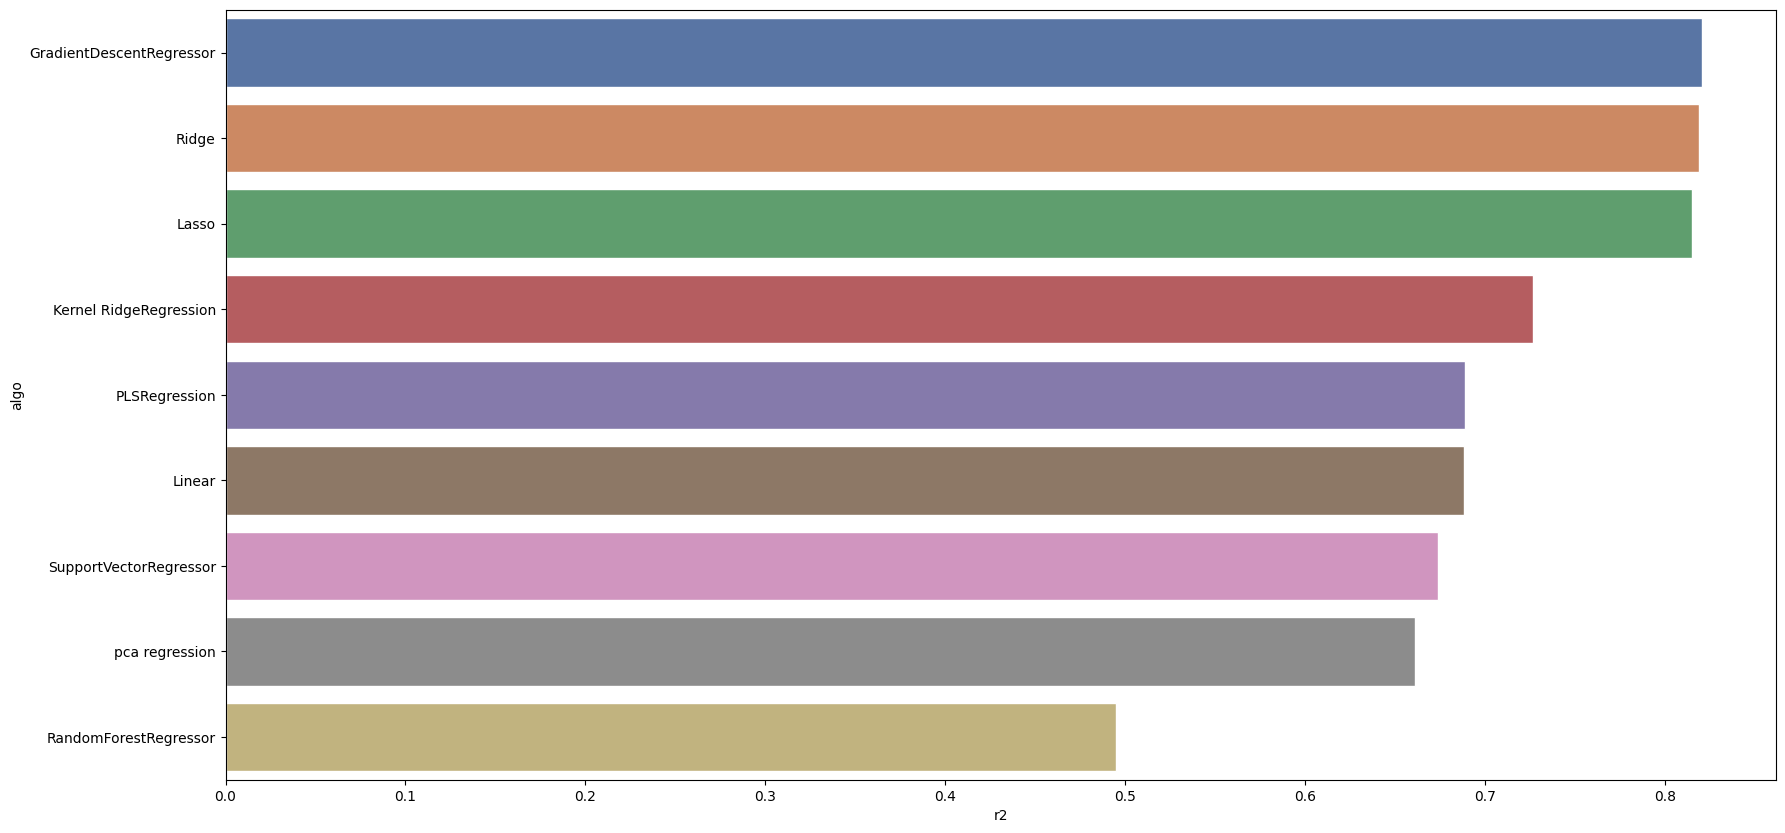

In [ ]:
# 본격적으로 여러개의 모델을 한번에 돌려서 성능을 비교해봅시다
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV , ElasticNetCV , RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

url = "http://lib.stat.cmu.edu/datasets/boston"
df = pd.read_csv(url, sep="\s+", skiprows=22, header=None)
data = np.hstack([df.values[::2, :], df.values[1::2, :2]])
target = df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=0)

cv = ShuffleSplit(n_splits=5 , test_size=0.3, random_state=42)

pipe_linear = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', LinearRegression())])
pipe_lasso = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Lasso(random_state = 42))])
pipe_ridge = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Ridge(random_state = 42))])
pipe_pca = Pipeline([
                ('scl', StandardScaler()),
                ('pca', PCA()),
                 ('fit', Ridge(random_state = 42))])
pipe_pls = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', PLS())])
pipe_gbr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', GBR())])
pipe_rfr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', RFR())])
pipe_svr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', SVR())])

pipe_KR = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', KernelRidge())])

grid_params_linear = [{
    "poly__degree" : np.arange(1,3),
    "fit__fit_intercept" : [True, False],
}]
grid_params_lasso = [{
    "poly__degree" : np.arange(1,3),
    "fit__tol" : np.logspace(-5,0,10) ,
    "fit__alpha" : np.logspace(-5,1,10) ,
                     }]
grid_params_pca = [{
    "pca__n_components" : np.arange(2,8)
}]
grid_params_ridge = [{
    "poly__degree" : np.arange(1,3),
    "fit__alpha" : np.linspace(2,5,10) ,
    "fit__solver" : [ "cholesky","lsqr","sparse_cg"] ,
    "fit__tol" : np.logspace(-5,0,10) ,
                     }]
grid_params_pls = [{
    "fit__n_components" : np.arange(2,8)
}]
min_samples_split_range = [0.5, 0.7 , 0.9]

grid_params_gbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] ,
    "fit__max_depth" : [5,6,7,8] ,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_rfr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__max_depth" : [5,6,7,8] ,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_svr =[{
    "fit__kernel" : ["rbf", "linear"] ,
    "fit__degree" : [2, 3, 5] ,
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
grid_params_KR =[{
    "fit__kernel" : ["rbf","linear"] ,
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
pipe = [
    pipe_linear , pipe_lasso ,  pipe_pca ,
    pipe_ridge , pipe_pls , pipe_gbr ,
    pipe_rfr , pipe_svr , pipe_KR
]

params = [
    grid_params_linear , grid_params_lasso , grid_params_pca,
    grid_params_ridge , grid_params_pls , grid_params_gbr ,
    grid_params_rfr , grid_params_svr , grid_params_KR
]

jobs = 20

grid_dict = {
    0: 'Linear',
    1: 'Lasso',
    2: 'pca regression' ,
    3: 'Ridge' ,
    4: 'PLSRegression',
    5: "GradientDescentRegressor" ,
    6: "RandomForestRegressor" ,
    7: "SupportVectorRegressor" ,
    8: "Kernel RidgeRegression"
            }

model_mse = {}
model_r2 = {}
model_best_params = {}

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param,scoring  = "neg_mean_squared_error" ,
                          cv=cv , n_jobs=jobs , verbose=-1 )
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
    model_mse[grid_dict.get(idx)] = mse(y_test, y_pred)
    model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)
    model_best_params[grid_dict.get(idx)] = search.best_params_
print("finish")


fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["algo","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="r2", data=output)
plt.show()

## 12.5 병렬화로 학습속도향상

In [ ]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
iris =datasets.load_iris()
feature, target = iris.data, iris.target
lr = linear_model.LogisticRegression()
penalty =['l1','l2']
C= np.logspace(0,4,1000)
hp = dict(C=C,penalty=penalty)
grid_cv = GridSearchCV(lr,hp,cv=5,n_jobs=-1,verbose=1)
best_model = grid_cv.fit(feature, target)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


## 12.6 LogisticRegressionCV로 모델선택속도 향상
- LogisticRegressionCV : 규제 C 의 최적값을 효율적으로 찾음 (C에대해서만 찾음)

In [ ]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
iris =datasets.load_iris()
feature, target = iris.data, iris.target
lr = linear_model.LogisticRegressionCV(Cs=100)
lr.fit(feature, target)

LogisticRegressionCV(Cs=100)

## 12.7 모델선택 후 성능평가
- 중첩 교차검증으로 편향 회피

In [ ]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
iris =datasets.load_iris()
feature, target = iris.data, iris.target
lr=linear_model.LogisticRegression(solver='liblinear',multi_class='auto')
C =np.logspace(0,4,20)
hp = dict(C=C)
grid_cv = GridSearchCV(lr,hp,cv=5,n_jobs=-1,verbose=0)
cross_val_score(grid_cv,feature,target,cv=3).mean()

0.9733333333333333